In [2]:
!pip install torchvision


In [3]:
import torch as t
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [4]:
from torchvision import datasets
datasets.MNIST.resources = [
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
            ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
        ]

In [5]:
mnist_trainset = datasets.MNIST(root="./data", train=True, download=True, transform=None)

0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
len(mnist_trainset)

60000

In [7]:
np.array(mnist_trainset[0][0]).shape

(28, 28)

In [8]:
device = t.device('cuda')

In [9]:
i = 0
ximgs = np.empty((60000, 28, 28, 1), dtype=np.float32)
y = np.empty((60000, 1),dtype=np.float32)

for img, label in mnist_trainset:
    img = np.array(img,dtype=np.float32)[:, :, np.newaxis]
    ximgs[i] = img
    y[i] = [label]
    i+=1
ximgs = t.from_numpy(ximgs)
ximgs = ximgs.permute(0,3,1,2)

In [10]:
class Encoder(nn.Module):
    def __init__(self, latent_space):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7744, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, latent_space),
            
        )
        
        self.means=  nn.Linear(latent_space, latent_space)
        self.variance = nn.Linear(latent_space, latent_space)
        
    def forward(self, inputs):
        x = self.model.forward(inputs)
        mu = self.means(x)
        sigma = nn.Sigmoid()(self.variance(x))
        
        return mu, sigma
  

In [11]:
class Decoder(nn.Module):
    def __init__(self, latent_space):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_space, 128),
            nn.ReLU(),
            nn.Linear(128, 7744),
            nn.ReLU(),
        )
        
        self.transconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1)
        self.transconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1)
        
        
    def forward(self,inputs):
        x = self.model.forward(inputs)
        x = x.view(-1, 64, 11, 11)
        x = nn.ReLU()(self.transconv1(x))
        x = self.transconv2(x)
        return x

In [40]:
class VAE(nn.Module):
    def __init__(self, latent_space=28):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_space)
        self.decoder = Decoder(latent_space)
        
        self.latent_space = latent_space
        
        musample = t.zeros([latent_space,], dtype=t.float32)
        sigmasample = t.ones([latent_space,],dtype=t.float32)
        self.normalDist = t.distributions.Normal(musample, sigmasample)
        self.kl = 0
        
    def encode(self, inputs):
        mu, sigma = self.encoder(inputs)
        z = mu + sigma * self.normalDist.rsample().to(device)
        
        self.kl = (sigma**2 + mu**2 - t.log(sigma) - 1/2).sum(dim=1).mean(dim=0)
        
        return z
    
    def forward(self, inputs):
        z = self.encode(inputs)
        return self.decoder(z)
    
    def save_model(self):
        t.save(self.encoder, "Encoder_weights")
        t.save(self.decoder, "Decoder_weights")
    
    def load_model(self):
        self.encoder = t.load("Encoder_weights")
        self.encoder.eval()
        
        self.decoder = t.load("Decoder_weights")
        self.decoder.eval()

In [28]:
v = VAE(10).to(device)

In [29]:
import tqdm

In [30]:
def train( data, epochs = 20):
    opt = t.optim.Adam(v.parameters())
    mse = nn.MSELoss()
    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(0, data.shape[0], 128):

            x = data[i:i+31].to(device)
            opt.zero_grad()
            x_hat = v(x)
            loss = mse(x, x_hat) + v.kl
            loss.backward()
            opt.step()
            epoch_loss += loss
        print(epoch_loss)

In [31]:
train(ximgs[:60000],10)

tensor(1647957.1250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1048954.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(868947.8125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(803655.5625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(762277., device='cuda:0', grad_fn=<AddBackward0>)
tensor(716070.1875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(684683.3125, device='cuda:0', grad_fn=<AddBackward0>)
tensor(663606.0625, device='cuda:0', grad_fn=<AddBackward0>)
tensor(648880.2500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(630440.2500, device='cuda:0', grad_fn=<AddBackward0>)


In [32]:
def show(arr):
    arr = arr.permute(1,2,0)
    plt.imshow(arr)

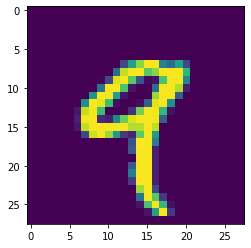

In [33]:
show(ximgs[4])

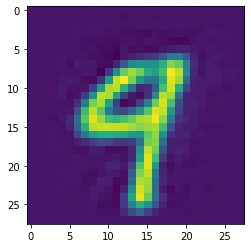

In [34]:
z = v(ximgs[4:5].to(device))[0].cpu().detach()
show(z)

In [35]:
v.save_model()

In [41]:
v2 = VAE(10).to(device)

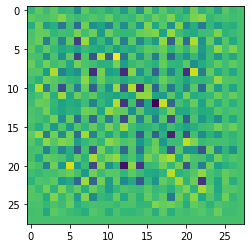

In [42]:
z = v2(ximgs[4:5].to(device))[0].cpu().detach()
show(z)

In [43]:
v2.load_model()

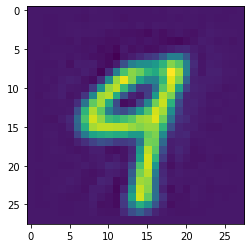

In [44]:
z = v2(ximgs[4:5].to(device))[0].cpu().detach()
show(z)